# Mem-RX<sup>*</sup> Audio Diffusion v0.2

> <sup>*</sup>**M**emcode **R**econstruction e**X**travaganza!

> Description: This is simple encoder-decoder demo which can serve as a starting point for operations that take advantage of the "tokens"/"embeddings" produced in the "middle" of the autoencoder. (If that doesn't excite you, ask a smart person.)

Authors: Zach Evans ([@zqevans](https://twitter.com/zqevans)) and Scott H. Hawley ([@drscotthawley](https://twitter.com/drscotthawley)), with diffusion code (used with permission) from Katherine Crowson ([@rivershavewings](https://twitter.com/rivershavewings)) 

## Setup

### Installation

In [ ]:
!pip install -Uqq aeiou einops 
!pip install -Uqq git+https://github.com/zqevans/audio-diffusion
!pip install -Uqq git+https://github.com/caillonantoine/cached_conv.git@a83851cfd1c68a7922c37c07343434b06ada63e0
!git clone --recursive https://github.com/zqevans/v-diffusion-pytorch

     |████████████████████████████████| 1.8 MB 21.0 MB/s 
     |████████████████████████████████| 143 kB 63.1 MB/s 
     |████████████████████████████████| 157 kB 73.3 MB/s 
     |████████████████████████████████| 181 kB 71.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 74.0 MB/s 
     |████████████████████████████████| 157 kB 78.1 MB/s 
     |████████████████████████████████| 157 kB 80.0 MB/s 
     |████████████████████████████████| 157 kB 70.0 MB/s 
     |████████████████████████████████| 157 kB 60.8 MB/s 
     |████████████████████████████████| 157 kB 42.6 MB/s 
     |████████████████████████████████| 156 kB 81.8 MB/s 
     |████████████████████████████████| 248 kB 13.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 706 kB 61.8 MB/s 
     |███████████████

### Imports

In [ ]:
from copy import deepcopy
import math
import os, sys
import subprocess
from collections import namedtuple
import numpy as np 
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import plotly.graph_objects as go

import torch
import torchaudio
from torch import optim, nn, Tensor
from torch import multiprocessing as mp
from torch.nn import functional as F
from torch.utils import data as torchdata

from einops import rearrange
from tqdm import trange
import pytorch_lightning as pl
from pytorch_lightning.utilities.distributed import rank_zero_only
from nwt_pytorch import Memcodes

from aeiou.core import load_audio
from aeiou.viz import embeddings_table, proj_pca, pca_point_cloud, show_pca_point_cloud, audio_spectrogram_image, tokens_spectrogram_image

# audio-diffusion imports
from diffusion.pqmf import CachedPQMF as PQMF
from encoders.encoders import AttnResEncoder1D
from autoencoders.soundstream import SoundStreamXLEncoder
from dvae.residual_memcodes import ResidualMemcodes
from decoders.diffusion_decoder import DiffusionAttnUnet1D
from diffusion.model import ema_update

## Define the Model

In [ ]:
# Define the noise schedule and sampling loop
def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def get_crash_schedule(t):
    sigma = torch.sin(t * math.pi / 2) ** 2
    alpha = (1 - sigma ** 2) ** 0.5
    return alpha_sigma_to_t(alpha, sigma)

def alpha_sigma_to_t(alpha, sigma):
    """Returns a timestep, given the scaling factors for the clean image and for
    the noise."""
    return torch.atan2(sigma, alpha) / math.pi * 2

@torch.no_grad()
def sample(model, x, steps, eta, logits):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]

    t = get_crash_schedule(t)
    
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * t[i], logits).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred



class DiffusionDVAE(pl.LightningModule):
    def __init__(self, global_args):
        super().__init__()

        self.pqmf_bands = global_args.pqmf_bands

        if self.pqmf_bands > 1:
            self.pqmf = PQMF(2, 70, global_args.pqmf_bands)

        capacity = 32

        c_mults = [2, 4, 8, 16, 32]
        
        strides = [4, 4, 2, 2, 2]

        self.encoder = SoundStreamXLEncoder(
            in_channels=2*global_args.pqmf_bands, 
            capacity=capacity, 
            latent_dim=global_args.latent_dim,
            c_mults = c_mults,
            strides = strides
        )
        self.encoder_ema = deepcopy(self.encoder)

        self.diffusion = DiffusionAttnUnet1D(
            io_channels=2, 
            cond_dim = global_args.latent_dim, 
            pqmf_bands = global_args.pqmf_bands, 
            n_attn_layers=4, 
            c_mults=[256, 256]+[512]*12
        )

        self.diffusion_ema = deepcopy(self.diffusion)
        self.rng = torch.quasirandom.SobolEngine(1, scramble=True)
        self.ema_decay = global_args.ema_decay
        
        self.num_quantizers = global_args.num_quantizers
        if self.num_quantizers > 0:
            quantizer_class = ResidualMemcodes if global_args.num_quantizers > 1 else Memcodes
            
            quantizer_kwargs = {}
            if global_args.num_quantizers > 1:
                quantizer_kwargs["num_quantizers"] = global_args.num_quantizers

            self.quantizer = quantizer_class(
                dim=global_args.latent_dim,
                heads=global_args.num_heads,
                num_codes=global_args.codebook_size,
                temperature=1.,
                **quantizer_kwargs
            )

            self.quantizer_ema = deepcopy(self.quantizer)

    def encode(self, *args, **kwargs):
        if self.training:
            return self.encoder(*args, **kwargs)
        return self.encoder_ema(*args, **kwargs)

    def decode(self, *args, **kwargs):
        if self.training:
            return self.diffusion(*args, **kwargs)
        return self.diffusion_ema(*args, **kwargs)


args_dict = {'num_quantizers':0, 'sample_size': 65536, 'sample_rate':48000, 'latent_dim': 64, 'pqmf_bands':1, 'ema_decay':0.995, 'num_quantizers':0}
global_args = namedtuple("global_args", args_dict.keys())(*args_dict.values())

## Load the Model Checkpoint
Checkpoint file (4 GB) is shareable at 

~~https://drive.google.com/file/d/1smLDqOHOpGj9jwjszXqmkq-XXFjeRZGy/view?usp=sharing~~ (old)

https://drive.google.com/file/d/1C3NMdQlmOcArGt1KL7pH32KtXVCOfXKr/view?usp=sharing


You'll have to click on that first and add it to your drive. 

If you put it in `MyDrive/AI/checkpoints/epoch=53-step=200000.ckpt`, then you can use the following code unaltered. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# ckpt_file = '/content/drive/MyDrive/AI/checkpoints/epoch=42-step=160000.ckpt' # older checkpoint
ckpt_file = '/content/drive/MyDrive/AI/checkpoints/epoch=53-step=200000.ckpt'
model = DiffusionDVAE.load_from_checkpoint(ckpt_file, global_args=global_args)

model.eval() # disable randomness, dropout, etc...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Supply Your Audio

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


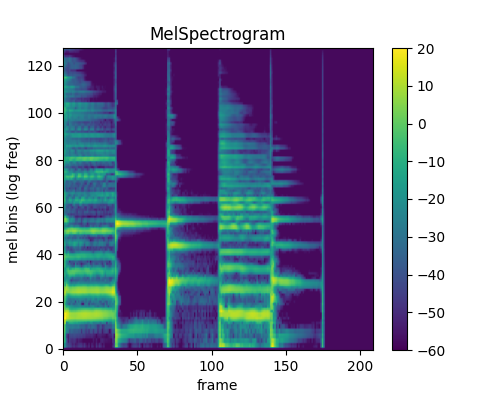

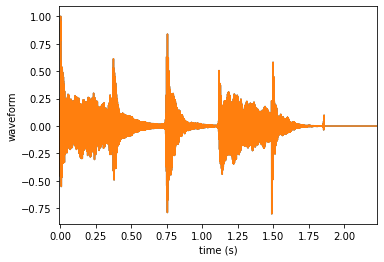

In [ ]:
#@markdown Provide Google Drive path to an audio file

audio_file = '/content/drive/MyDrive/AI/mem-rx-test.wav'  #@param{type:"string"}

audio_in = load_audio(audio_file, sr=global_args.sample_rate)

from IPython.display import display, Audio # to display images
import matplotlib.pyplot as plt

def plot_and_hear(audio, sr=48000):
    """
    plot and hear a cuda tensor of sound.... TODO: make spectrogram and waveform graph's widths match up
    """
    print("\n") # without this you can't access the download button 
    display(Audio(audio.cpu(), rate=sr))
    spec_graph = audio_spectrogram_image(audio)
    display(spec_graph)
    fig, axs = plt.subplots(figsize=(5.7,4))
    t = torch.arange(audio.shape[-1]).cpu().t().numpy()/sr
    axs.plot(t, audio.cpu().t().numpy())
    axs.set_ylabel('waveform')
    axs.set_xlabel('time (s)')
    axs.set_xlim((-1e-2,t[-1]))
    

plot_and_hear(audio_in, sr=global_args.sample_rate)

## Encode Audio into "Embeddings"

First, we need to chop up the audio into batches 

In [ ]:
def batch_it_crazy(x, win_len):
    "(pun intended) Chop up long sequence into a batch of win_len windows"
    x_len = x.size()[-1]
    n_windows = (x_len // win_len) + 1
    pad_amt = win_len * n_windows - x_len  # pad end w. zeros to make lengths even when split
    xpad = F.pad(x, (0, pad_amt))
    return rearrange(xpad, 'd (b n) -> b d n', n=win_len)


demo_reals = batch_it_crazy(audio_in, global_args.sample_size)

max_batch_size = 8
if demo_reals.size()[0] > max_batch_size:
    print(f"Warning: Due to CUDA memory limits, we're cutting you off at a batch size of {max_batch_size}")
    demo_reals = demo_reals[0:max_batch_size,:,:]

print(f"demo_reals.shape = {demo_reals.shape}\ni.e. {demo_reals.shape[0]} batches")

demo_reals.shape = torch.Size([2, 2, 65536])
i.e. 2 batches


Then we can encode it using the model's `encoder_ema` function...

In [ ]:
def encode_it(demo_reals, module):
    encoder_input = demo_reals
    
    if module.pqmf_bands > 1:
        encoder_input = module.pqmf(demo_reals)
    
    encoder_input = encoder_input.to(module.device)

    demo_reals = demo_reals.to(module.device)

    noise = torch.randn([demo_reals.shape[0], 2, module.demo_samples]).to(module.device)
    
    with torch.no_grad():

        embeddings = module.encoder_ema(encoder_input)

        if module.quantized:

            #Rearrange for Memcodes
            embeddings = rearrange(embeddings, 'b d n -> b n d')
            embeddings, _= module.quantizer_ema(embeddings)
            embeddings = rearrange(embeddings, 'b n d -> b d n')
        
        embeddings = torch.tanh(embeddings)
        return embeddings, noise

# attach some arg values to the model 
model.demo_samples = global_args.sample_size 
model.quantized = global_args.num_quantizers > 0

embeddings, noise = encode_it(demo_reals, model) # ENCODING! 

print(f"Encoded to embeddings.shape =",embeddings.shape)
print(f"            and noise.shape =",noise.shape)

Encoded to embeddings.shape = torch.Size([2, 64, 512])
            and noise.shape = torch.Size([2, 2, 65536])


## Reconstruct (output) Audio from Embeddings
This will use a diffusion sampler so it will take a little while...

In [ ]:
#@title Perform reconstruction using  \_\_this many\_\_ steps
demo_steps = 35 #@param {type:"slider", min:10, max:100, step:1}

fake_batches = sample(model.diffusion_ema, noise, demo_steps, 0, embeddings)

audio_out = rearrange(fake_batches, 'b d n -> d (b n)') # Put the demos together
plot_and_hear(audio_out.cpu())

100%|██████████| 35/35 [00:30<00:00,  1.14it/s]


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.



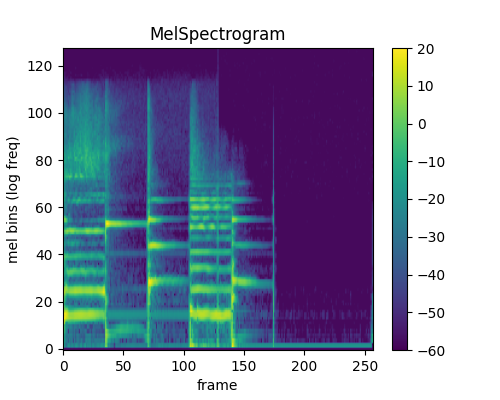

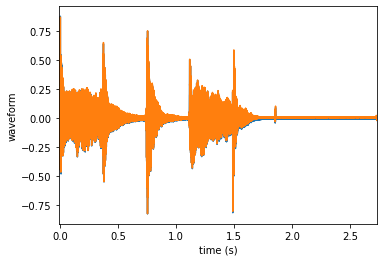

In [ ]:
audio_out = rearrange(fake_batches, 'b d n -> d (b n)') # Put the demos together
plot_and_hear(audio_out.cpu())

...and show the original/"real" audio one more time, for comparison:

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


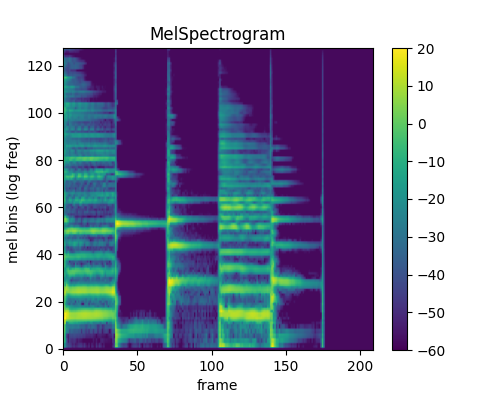

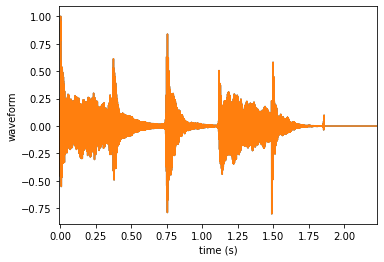

In [ ]:
plot_and_hear(audio_in)

# Operate on the Embeddings

In [ ]:
print(embeddings.shape) # b,d,n:  batches, dimensions, time-samples.  each time-sample exists in d dimensions

torch.Size([2, 64, 512])


Perform some kind of (mathematical) operation in "embedding space" 

In [ ]:
# modify with a some random variation in all things.
rand_fac = 0.5

# 'MATH OPTIONS' below for messing with the sound....

#embeddings2 = -embeddings + rand_fac*embeddings*(2*torch.rand_like(embeddings)-1)       # "phasey left-right call-and-response noise"
#embeddings2 = (1-rand_fac)*embeddings + rand_fac*embeddings*(2*torch.rand_like(embeddings)-1)  # 'hurt drums'
#embeddings2 = embeddings.flip(dims=[1])                                                 # Swap dem memcodes
#embeddings2 = torch.max(embeddings)*(torch.sign(embeddings) - embeddings)                # Scott calls this one 'Destructo'
#embeddings2 = torch.max(torch.abs(embeddings)) - embeddings                             # 'Destructo2'
#embeddings2 = 2*embeddings                                                             # 'big changes afoot'
#embeddings2 = torch.flip(embeddings,[2])                                               # time reversal of tokens
#embeddings2 = embeddings.clone() + torch.flip(embeddings,[-1])
#embeddings2[:,33:-1,:] = 0. # kill half
embeddings2 = torch.max(embeddings)*torch.tanh(10*embeddings)                            # overdrive? 
# WRITE YOUR OWN!
# embeddings2 = ....

print(torch.min(embeddings), torch.max(embeddings))
print(torch.min(embeddings2), torch.max(embeddings2))

tensor(-0.6127, device='cuda:0') tensor(0.6007, device='cuda:0')
tensor(-0.6007, device='cuda:0') tensor(0.6007, device='cuda:0')


## Visualizing embeddings, before & after that operation

viz code (now in aeiou.viz v0.0.10)

In [ ]:
'''
def pca_point_cloud(tokens, color_scheme='batch', points_only=False):
    "produces a 3D wandb point cloud of the tokens using PCA. tokens has shape (b, d, n)"
    data = proj_pca(tokens).cpu().numpy()
    points = []
    if color_scheme=='batch':
        cmap, norm = cm.tab20, Normalize(vmin=0, vmax=data.shape[0])
    else: 
        cmap, norm = cm.viridis, Normalize(vmin=0, vmax=data.shape[1])
    for bi in range(data.shape[0]):  # batch index
        if color_scheme=='batch': [r, g, b, _] = [int(255*x) for x in cmap(norm(bi))] 
        for n in range(data.shape[1]):
            if color_scheme!='batch': [r, g, b, _] = [int(255*x) for x in cmap(norm(n))] 
            points.append([data[bi,n,0], data[bi,n,1], data[bi,n,2], r, g, b])

    point_cloud = np.array(points)
    return point_cloud if points_only else wandb.Object3D(point_cloud)


def show_pca_point_cloud(tokens):
    "use plotly to display a 3d scatter plot of tokens"
    pc_arr = pca_point_cloud(tokens, points_only=True)
    fig = go.Figure(data=[go.Scatter3d(x=pc_arr[:,0], y=pc_arr[:,1], z=pc_arr[:,2],
                mode='markers', marker=dict(size=3, opacity=0.6, color=pc_arr[:,3:6]))])
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) # tight layout
    fig.show()
'''

"Embeddings spectrograms", before & after:

tokens_spectrogram_image: embeddings.shape =  torch.Size([1024, 64])


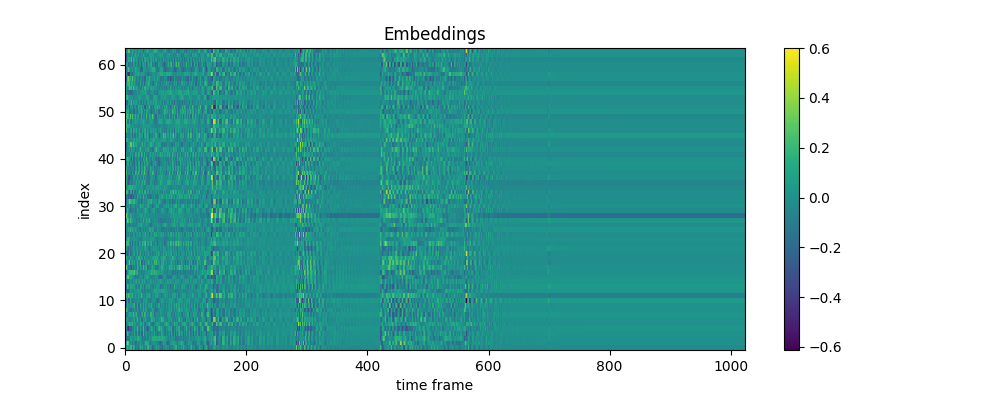

tokens_spectrogram_image: embeddings.shape =  torch.Size([1024, 64])


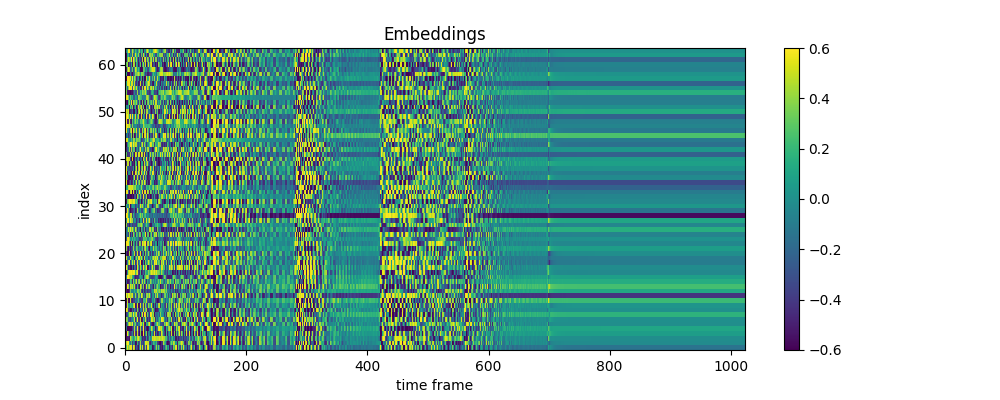

In [ ]:
display(tokens_spectrogram_image(embeddings))
display(tokens_spectrogram_image(embeddings2))

3D Point Clouds, before & after:

In [ ]:
show_pca_point_cloud(embeddings) 
show_pca_point_cloud(embeddings2) 

Now we decode & listen to the embeddings that were the result of that operation

100%|██████████| 35/35 [00:30<00:00,  1.14it/s]


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.



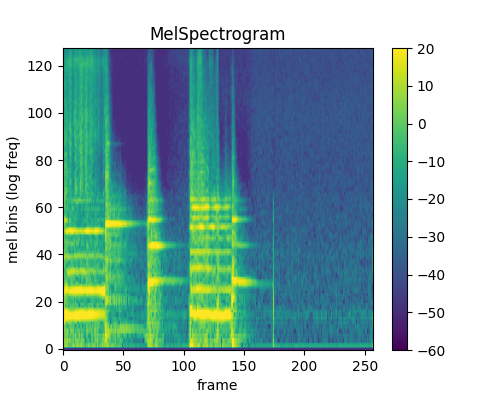

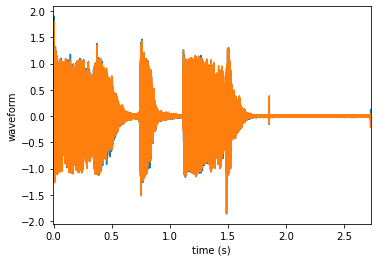

In [ ]:
fake_batches2 = sample(model.diffusion_ema, noise, demo_steps, 0, embeddings2)
audio_out2 = rearrange(fake_batches2, 'b d n -> d (b n)') # Put the demos together
plot_and_hear(audio_out2.cpu())